# Building Machine Learning Systems with Python - Chapter 11

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/) and [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/)  published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Nov  8 2017, 15:10:56) [MSC v.1900 64 bit (AMD64)]'

In [2]:
from matplotlib import pyplot as plt
import numpy as np

Magic command to get inline plots:

In [3]:
%matplotlib inline

We load the data with `load_iris` from `sklearn`

In [4]:
from sklearn.datasets import load_iris
data = load_iris()

`load_iris` returns an object with several fields

In [5]:
features = data.data
feature_names = data.feature_names
target = data.target
target_names = data.target_names

We use NumPy fancy indexing to get an array of strings:


In [6]:
labels = target_names[target]

We plot all the 2D projections of the features (since there are only 4 of them):

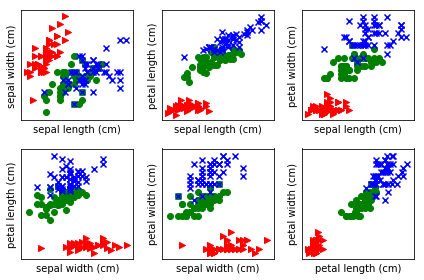

In [7]:
fig,axes = plt.subplots(2, 3)
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

# Set up 3 different pairs of (color, marker)
color_markers = [
        ('r', '>'),
        ('g', 'o'),
        ('b', 'x'),
        ]
for i, (p0, p1) in enumerate(pairs):
    ax = axes.flat[i]

    for t in range(3):
        # Use a different color/marker for each class `t`
        c,marker = color_markers[t]
        ax.scatter(features[target == t, p0], features[
                    target == t, p1], marker=marker, c=c)
    ax.set_xlabel(feature_names[p0])
    ax.set_ylabel(feature_names[p1])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

Learning a classification model (a decision tree):

In [8]:
from sklearn import tree

tr = tree.DecisionTreeClassifier(min_samples_leaf=10)

`fit` performs the learning (fits the model):

In [9]:
tr.fit(features, labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Plotting the decision tree (using an intermediate file):

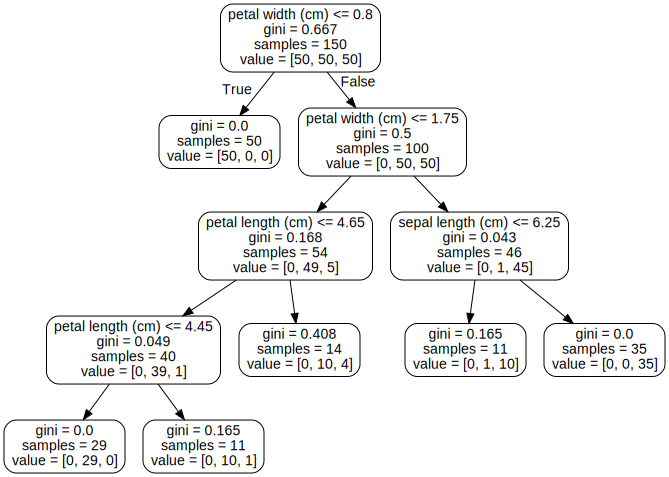

In [10]:
import graphviz
tree.export_graphviz(tr, feature_names=feature_names, rounded=True, out_file='decision.dot')

graphviz.Source(open('decision.dot').read())

Evaluating performance on the training set (which is **not the right way to do it**: see the discussion in the book)

In [11]:
prediction = tr.predict(features)
print("Accuracy: {:.1%}".format(np.mean(prediction == labels)))

Accuracy: 96.0%


Leave-one-out crossvalidation (a good way to do it):

In [12]:
predictions = []
for i in range(len(features)):
    train_features = np.delete(features, i, axis=0)
    train_labels = np.delete(labels, i, axis=0)
    tr.fit(train_features, train_labels)
    predictions.append(tr.predict([features[i]]))
predictions = np.array(predictions)

Compare the LOO predictions with the gold set:

In [13]:
print("Accuracy (with LOO CV): {:.1%}".format(np.mean(predictions.ravel() == labels)))

Accuracy (with LOO CV): 95.3%


We can do the same leave-on-out cross validation with scikit-learn's `model_selection` module:

In [14]:
from sklearn import model_selection

predictions = model_selection.cross_val_predict(
    tr,
    features,
    labels,
    cv=model_selection.LeaveOneOut())
print(np.mean(predictions == labels))

0.953333333333


## The seeds dataset

A slightly more complex dataset

In [15]:
from load import load_dataset

feature_names = [
    'area',
    'perimeter',
    'compactness',
    'length of kernel',
    'width of kernel',
    'asymmetry coefficien',
    'length of kernel groove',
]
data = load_dataset('seeds')
features = data['features']
target = data['target']

We now try a _nearest neighbors_ classifier

In [16]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

Everything is similar to what we had before

In [17]:
kf = model_selection.KFold(n_splits=5, shuffle=False)
means = []
for training,testing in kf.split(features):
   # We learn a model for this fold with `fit` and then apply it to the
   # testing data with `predict`:
   knn.fit(features[training], target[training])
   prediction = knn.predict(features[testing])

   # np.mean on an array of booleans returns fraction
 # of correct decisions for this fold:
   curmean = np.mean(prediction == target[testing])
   means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=5)
classifier = Pipeline([('norm', StandardScaler()), ('knn', classifier)])

means = []
for training,testing in kf.split(features):
    # We learn a model for this fold with `fit` and then apply it to the
    # testing data with `predict`:
    classifier.fit(features[training], target[training])
    prediction = classifier.predict(features[testing])

    # np.mean on an array of booleans returns fraction
    # of correct decisions for this fold:
    curmean = np.mean(prediction == target[testing])
    means.append(curmean)
print('Mean accuracy: {:.1%}'.format(np.mean(means)))

Mean accuracy: 83.8%
Mean accuracy: 86.7%


In [18]:
def plot_decision_space(clf, features, target, use_color=True):
    from matplotlib.colors import ListedColormap

    clf.fit(features[:, [0,2]], target)

    y0, y1 = features[:, 2].min() * .9, features[:, 2].max() * 1.1
    x0, x1 = features[:, 0].min() * .9, features[:, 0].max() * 1.1
    X = np.linspace(x0, x1, 1000)
    Y = np.linspace(y0, y1, 1000)
    X, Y = np.meshgrid(X, Y)
    C = clf.predict(np.vstack([X.ravel(), Y.ravel()]).T).reshape(X.shape)
    if use_color:
        cmap = ListedColormap([(1., .7, .7), (.7, 1., .7), (.7, .7, 1.)])
    else:
        cmap = ListedColormap([(1., 1., 1.), (.2, .2, .2), (.6, .6, .6)])

    fig,ax = plt.subplots()
    ax.scatter(features[:, 0], features[:, 2], c=target, cmap=cmap)
    for lab, ma in zip(range(3), "Do^"):
        ax.plot(features[target == lab, 0], features[
                 target == lab, 2], ma, c=(1., 1., 1.), ms=6)

    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[2])
    ax.pcolormesh(X, Y, C, cmap=cmap)
    return fig

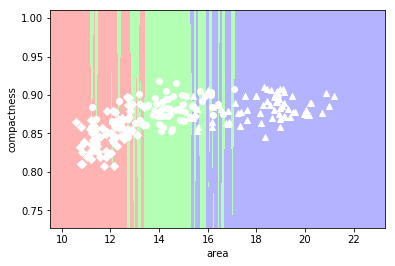

In [19]:
_ = plot_decision_space(knn, features, target)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

classifier = KNeighborsClassifier(n_neighbors=1)
classifier = Pipeline([('norm', StandardScaler()),
                       ('knn', classifier)])

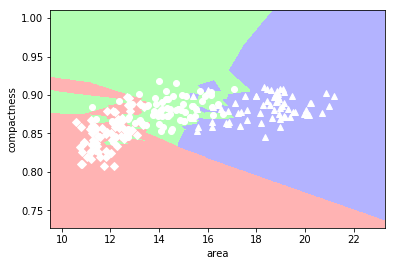

In [21]:
_ = plot_decision_space(classifier, features, target)

# Random forests

See the excellent paper [Do we Need Hundreds of Classifiers to Solve Real World Classification Problems?](http://jmlr.org/papers/v15/delgado14a.html) by Delgado et al. (2014) to understand why we recommend random forests as the default classifier.

In [22]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100)

Again, use cross-validation to evaluate:

In [23]:
predict = model_selection.cross_val_predict(rf, features, target)
print("RF accuracy: {:.1%}".format(np.mean(predict == target)))

RF accuracy: 86.7%


Not in the book, but we can also plot the decision function for a random forest:

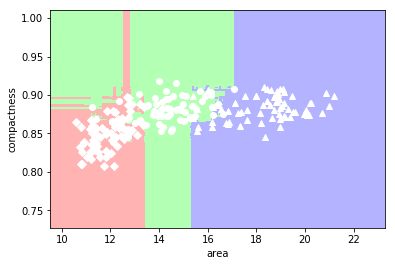

In [24]:
_= plot_decision_space(rf, features, target)